In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import os
import pickle
import json
import re
from PIL import Image

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# create giant dictionary for all data
data_dir = '../facebook_challenge_data/'
model_dir = 'models/'

def get_dict(path):
    data_dict = OrderedDict()
    jsonl_content = open(path, 'r').read()
    data = [json.loads(jline) for jline in jsonl_content.split('\n')]
    for datum in data: data_dict[datum['id']] = datum
    return data_dict

train_dict = get_dict(data_dir + 'train.jsonl')
val_dict = get_dict(data_dir + 'dev.jsonl')
test_dict = get_dict(data_dir + 'test.jsonl')

print(len(train_dict))
print(len(val_dict))
print(len(test_dict))

8500
500
1000


In [4]:
from random import randint # for random cropping
from tensorflow.keras.preprocessing.sequence import pad_sequences

class FBMMDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_dict, tokenizer, pad_len, batch_size=32, dim=(299, 299), 
                 n_channels=3, shuffle=True, test=False):
        'Initialization'
        self.dim = dim
        self.data_dict = data_dict
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.pad_len = pad_len
        self.tokenizer = tokenizer
        
        # build labels list and id list
        self.id_list = list(self.data_dict.keys())
        self.img_list = {ID: self.data_dict[ID]['img'] for ID in self.id_list}
        if test: self.labels = {ID: 0 for ID in self.id_list}
        else: self.labels = {ID: self.data_dict[ID]['label'] for ID in self.id_list}
            
        # get text dictionary
        self.text_dict = self.process_text(self.id_list)
        
        self.on_epoch_end()
        self.classes = [self.labels[self.id_list[i]] for i in self.indexes]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X_txt, X_img, y = self.__data_generation(id_list_temp)
        
        return (X_txt, X_img), y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_img = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        X_txt = np.empty((len(id_list_temp), self.pad_len))
        y = np.empty(len(id_list_temp), dtype=int)

        # Generate data
        for i, ID in enumerate(id_list_temp):
            # Store sample
            X_img[i,] = self.process_img(data_dir + self.img_list[ID])
            X_txt[i,] = self.text_dict[ID]

            # Store class
            y[i] = self.labels[ID]

        return X_txt.astype(int), X_img, y
    
    def process_img(self, path): # method for getting image
        img = Image.open(path)
        img.load()
        scale_size = int(self.dim[0]) # want cropping
        if img.size[0] < img.size[1]: # width greater than height
            wpercent = (scale_size/float(img.size[0]))
            hsize = int((float(img.size[1])*float(wpercent)))
            img = img.resize((scale_size,hsize), Image.ANTIALIAS)
        else: # height greater than width
            hpercent = (scale_size/float(img.size[1]))
            wsize = int((float(img.size[0])*float(hpercent)))
            img = img.resize((wsize, scale_size), Image.ANTIALIAS)
            
        data = np.asarray(img, dtype='uint8')
        im = self.augment(data) # apply transformation
        
        
        if im.shape==(self.dim[0], self.dim[1]): im = np.stack((im,)*3, axis=-1) # handle grayscale
        if im.shape == (*self.dim, 4): im = im[:,:,:3] # handle weird case
        
        return im
    
    def augment(self, im): # random crop and random mirror
        
        # random crop
        x_max, y_max = im.shape[0], im.shape[1]
        x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
        im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
        # random mirror
        if randint(0,1): im = np.flip(im, axis=1)
        
        return im
    
    def process_text(self, id_list):
        
        # matrix for texts
        texts = [self.data_dict[ID]['text'] for ID in id_list]
        sequences = [self.tokenizer.encode(text) for text in texts] # make this more efficient...
        text_seqs = pad_sequences(sequences, maxlen=self.pad_len)
        
        id_to_seq = {ID: txt for (ID, txt) in zip(id_list, text_seqs)} # map id to text seq
        
        return id_to_seq

In [5]:
from transformers import AutoConfig, AutoTokenizer, TFRobertaModel
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_len = 100
scale_factor = 3
batch_size = 16

# create data generators
train_gen = FBMMDataGenerator(data_dict=train_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(224*scale_factor, 224*scale_factor),
                          n_channels=3,
                          shuffle=True)

val_gen = FBMMDataGenerator(data_dict=val_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(224*scale_factor, 224*scale_factor),
                          n_channels=3,
                          shuffle=True)

# Define model

In [6]:
import transformers

from tensorflow.keras import layers

class BERT(transformers.TFBertModel):
    def __init__(self, config, *inputs, **kwargs):
        super(BERT, self).__init__(config, *inputs, **kwargs)
        self.bert.call = tf.function(self.bert.call)


class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.resnet = tf.keras.applications.ResNet50V2(include_top=False, 
                                                             weights='imagenet', 
                                                             input_shape=(224, 224, 3))
        for layer in self.resnet.layers[:-1]: layer.trainable = False
        
        self.bert = BERT.from_pretrained('bert-base-uncased')
        
        self.text_embedding = self.bert.get_input_embeddings().word_embeddings
        
        # handle image
        self.crop_ranges = [(0, 224), (224, 448), (448, 672)]
        self.croppings = [((xs[0], 672-xs[1]), (ys[0], 672-ys[1]))
                          for xs in self.crop_ranges for ys in self.crop_ranges]
        print(self.croppings)
        self.cropping_layers = [layers.Cropping2D(cropping) for cropping in self.croppings]
                                
        self.pool = layers.GlobalAveragePooling2D()
        self.W_ns = [layers.Dense(self.bert.config.hidden_size) for _ in range(len(self.crop_ranges)**2)]
        
        self.concat = layers.Concatenate(axis=1)
        
        self.dropout = layers.Dropout(0.1)
        self.denseout = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        text, image = inputs
        
        # handle image
        images = [crop(image) for crop in self.cropping_layers]
        # print(1, [image.shape for image in images])
        images = [tf.keras.applications.resnet_v2.preprocess_input(image) for image in images]
        # print(2, [image.shape for image in images])
        image_embs = [self.resnet(image) for image in images]
        # print(3, [image.shape for image in image_embs])
        image_embs = [self.pool(image) for image in image_embs]
        # print(4, [image.shape for image in image_embs])
        image_embeds = [self.W_ns[i](image_embs[i]) for i in range(len(self.W_ns))]
        # print(5, image_embeds[0].shape)
        image_emb = tf.keras.backend.stack(image_embeds, axis=1)

        
        # handle text
        text_emb = tf.gather(self.text_embedding, text)
        
        # concat and feed to bert
        concat_emb = self.concat([text_emb, image_emb])
        seg_ids = np.concatenate((np.zeros(max_len, dtype=np.int64), 
                                  np.ones(len(self.crop_ranges)**2, dtype=np.int64)))
        bert_encodings = self.bert(inputs={'inputs_embeds': concat_emb,
                                                'token_type_ids': seg_ids})[0]
        doc_encoding = tf.squeeze(bert_encodings[:, 0:1, :], axis=1)
        doc_encoding = self.dropout(doc_encoding)
        
        output = self.denseout(doc_encoding)
        
        return output

model = MyModel()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BERT: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing BERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of BERT were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use BERT for predictions without further training.


ListWrapper([((0, 448), (0, 448)), ((0, 448), (224, 224)), ((0, 448), (448, 0)), ((224, 224), (0, 448)), ((224, 224), (224, 224)), ((224, 224), (448, 0)), ((448, 0), (0, 448)), ((448, 0), (224, 224)), ((448, 0), (448, 0))])


In [7]:
optimizer = tf.keras.optimizers.Adam(lr=5e-6)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [8]:
# train model
from tensorflow.keras.callbacks import ModelCheckpoint

weight_file = 'best_vis_bert_weights_fb.h5'

mcp_save = ModelCheckpoint(model_dir + weight_file, 
                           save_weights_only=True, 
                           save_best_only=True, 
                           verbose=1,
                           monitor='val_auc', 
                           mode='max')

history = model.fit(train_gen,
                    validation_data=val_gen,
                    shuffle=True,
                    epochs=10,
                    callbacks=[mcp_save])

Epoch 1/10
532/532 [==============================] - ETA: 0s - loss: 0.6184 - accuracy: 0.6685 - auc: 0.6462
Epoch 00001: val_auc improved from -inf to 0.63855, saving model to models/best_vis_bert_weights_fb.h5
532/532 [==============================] - 900s 2s/step - loss: 0.6184 - accuracy: 0.6685 - auc: 0.6462 - val_loss: 0.7222 - val_accuracy: 0.5740 - val_auc: 0.6386
Epoch 2/10
532/532 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7373 - auc: 0.7655
Epoch 00002: val_auc improved from 0.63855 to 0.64310, saving model to models/best_vis_bert_weights_fb.h5
532/532 [==============================] - 891s 2s/step - loss: 0.5436 - accuracy: 0.7373 - auc: 0.7655 - val_loss: 0.9102 - val_accuracy: 0.5520 - val_auc: 0.6431
Epoch 3/10
532/532 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.7480 - auc: 0.8014
Epoch 00003: val_auc improved from 0.64310 to 0.65324, saving model to models/best_vis_bert_weights_fb.h5
532/532 [==================

In [9]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
bert (BERT)                  multiple                  109482240 
_________________________________________________________________
cropping2d (Cropping2D)      multiple                  0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    multiple                  0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    multiple                  0         
_________________________________________________________________
cropping2d_3 (Cropping2D)    multiple                  0         
_________________________________________________________________
cropping2d_4 (Cropping2D)    multiple                  0  

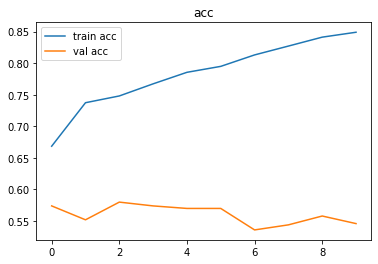

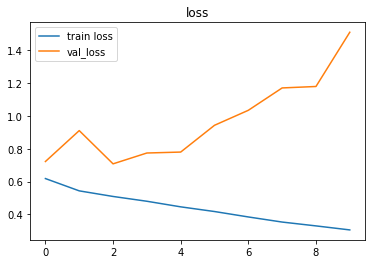

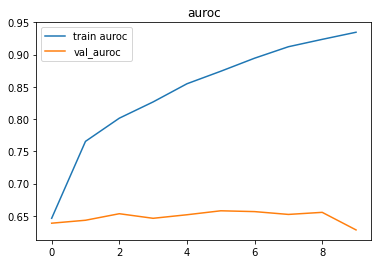

In [10]:
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.title('acc')
plt.show()

plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(history.history['auc'], label = 'train auroc')
plt.plot(history.history['val_auc'], label = 'val_auroc')
plt.legend()
plt.title('auroc')
plt.show()

In [11]:
model.load_weights(model_dir + weight_file)

In [12]:
val_gen = FBMMDataGenerator(data_dict=val_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(224*scale_factor, 224*scale_factor),
                          n_channels=3,
                          shuffle=True)

In [13]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import math

y_val = val_gen.classes

# get AUROC
val_preds = model.predict(val_gen)
print('Val AUROC:', roc_auc_score(y_val, val_preds))

# get optimal threhold
mx, thresh = 0, 0
preds_bin = np.array(val_preds)

for t in np.linspace(0, 1, 101):
    preds_bin[val_preds >= t] = 1
    preds_bin[val_preds < t] = 0
    acc = accuracy_score(y_val, preds_bin)
    if acc > mx: mx, thresh = acc, t
        
# print(thresh)

# get loss and acc
preds_bin = np.array(val_preds)
preds_bin[val_preds>thresh] = 1
preds_bin[val_preds<=thresh] = 0
print('Val Accuracy:', accuracy_score(y_val, preds_bin))

# get F1
print('Test F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_val, preds_bin, zero_division=1))

Val AUROC: 0.65432
Val Accuracy: 0.62
Test F1: 0.6822742474916388
Test Precision: 0.5862068965517241
Test Recall: 0.816


In [ ]:
test_gen = FBMMDataGenerator(data_dict=test_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(416, 416),
                          n_channels=3,
                          shuffle=False,
                          test=True)

ids = test_gen.id_list

preds = model.predict(test_gen)
preds = np.squeeze(preds)

preds_bin = np.array(preds)
preds_bin[preds >= thresh] = 1
preds_bin[preds < thresh] = 0

# write to csv
import csv

with open('grid_visbert_submission.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(["id", "proba", "label"])
    for ID, prob, lab in zip(ids, preds, preds_bin):
        wr.writerow([ID, prob, int(lab)])